In [1]:
# Import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cmaps
import xesmf as xe

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as feature
from cartopy.util import add_cyclic_point

In [2]:
# File paths and names
file_dir = "/scratch/racosta6/resolution-test/"
file1_name = "F.1850x2.0_C5_280_ihesp1046.01_ANN_concat.nc"
file2_name = "F.1850x1.0_C5_280_ihesp1046.01_ANN_concat.nc"
file3_name = "F.1850x0.25_C5_280_ihesp1046.01_ANN_concat.nc"

# Load in datasets
ds1 = xr.open_dataset(file_dir + file1_name)
ds2 = xr.open_dataset(file_dir + file2_name)
ds3 = xr.open_dataset(file_dir + file3_name)

In [3]:
ds1

<xarray.Dataset>
Dimensions:        (time: 12, lat: 96, lon: 144, lev: 30, ilev: 31, slat: 95, slon: 144, nbnd: 2)
Coordinates:
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon           (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
  * time           (time) object 0010-08-02 12:00:00 ... 0011-07-02 12:00:00
Dimensions without coordinates: nbnd
Data variables: (12/167)
    AEROD_v        (time, lat, lon) float32 ...
    ANRAIN         (time, lev, lat, lon) float32 ...
    ANSNOW         (time, lev, lat, lon) float32 ...
    AODDUST1       (time, lat, lon) float32 ...
    AODDUST3       (time, lat, lon) float32 ...
    AODVIS         (time, lat, lon) float32 ...
    ...             ...
    soa_a2_SRF     (time, lat, lon) float32 ...
    sol_tsi        (time) float64 ...
    time_bnds      (time, nbnd) object ...
    time_written   (time) |S8 ...
    w_stag         (slat) float64 ...
    wnummax        (lat) int32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             F.1850x2.0_C5_280_ihesp1046.01
    title:            UNSET
    logname:          pacosta
    host:             derecho3
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/derecho/scratch/pacosta/F.1850x2.0_C5_280_ihesp1...
    topography_file:  /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/co...
    history:          Sun Jul  7 06:50:49 2024: ncrcat -O F.1850x2.0_C5_280_i...
    NCO:              netCDF Operators version 5.1.9 (Homepage = http://nco.s...

In [4]:
# Function to streamline plotting
def anom_panel_plot(res1_ann, res3_ann, start_levels, end_levels, titles, cbar_title, allcmaps, path, save, extent=[-180, 180, -90, 90], lon_step=60, lat_step=30, step=0.5):
    # Regrid
    dstgrid = xr.Dataset({'lat': (['lat'], np.linspace(-90,90,181)),
                        'lon': (['lon'], np.linspace(0,359,360)),})

    # --regridder -- 
    regridder1 = xe.Regridder(res1_ann, dstgrid, 'bilinear', periodic= True)
    regridder3 = xe.Regridder(res3_ann, dstgrid, 'bilinear', periodic= True)

    # Do regridding
    res1_reg = regridder1(res1_ann)
    res3_reg = regridder3(res3_ann)

    # Calculate the anomaly
    anom = res3_reg - res1_reg

    ds_arr = [res1_ann, anom, res3_ann]

    # Define the figure and each axis for the 1 rows and 3 columns
    fig, axs = plt.subplots(nrows=1, ncols=3,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(16, 5.5))

    # Loop over all of the datasets and plot
    for i in range(len(ds_arr)):

        # Select the dataset
        data = ds_arr[i]

        # Add the cyclic point
        data, lons = add_cyclic_point(data, coord=data['lon'])

        # Adjust the levels so that the color gradient accurately represents the data
        steps = np.arange(start_levels[i], end_levels[i], step)

        # Contour plot
        cs = axs[i].contourf(lons, ds_arr[i].lat, data, levels=steps,
                            transform=ccrs.PlateCarree(),
                            cmap=allcmaps[i], extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(titles[i])

        axs[i].set_extent(extent, crs=ccrs.PlateCarree())

        # Draw the coastines for each subplot
        axs[i].coastlines()

        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(extent[0], extent[1] + 1, lon_step), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(np.arange(extent[2], extent[3] + 1, lat_step), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Add a colorbar and title it
        cbar = plt.colorbar(cs, ax=axs[i], orientation='horizontal')
        cbar.set_label(cbar_title)
        cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))

    # Save the figure, or don't, show figure either way
    if save == True:
        plt.savefig(fname=path, format='pdf')
        plt.show()
    else:
        plt.show()

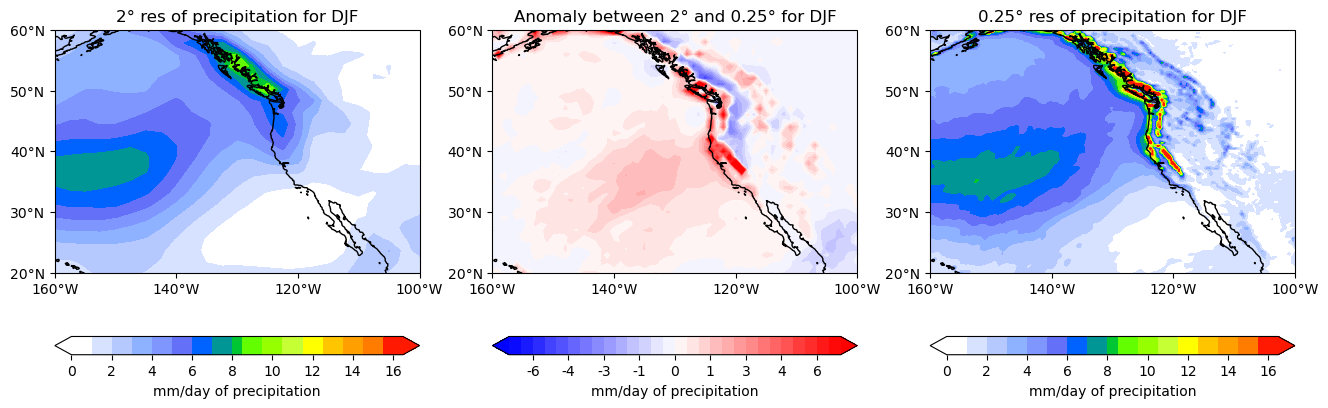

In [8]:
# Get DJF for CESM PRECC
CESM1_200 = ds1.PRECC[0:2,:,:]
CESM1_2 = ds1.PRECC[11,:,:]

# Get DJF for CESM PRECL
CESM2 = ds1.PRECL[0:2,:,:]
CESM2_2 = ds1.PRECL[11,:,:]

# Concat PRECC and PRECL independently to get DJF for each
CESM1_djf = xr.concat([CESM1_200, CESM1_2], dim='time')
CESM2_djf = xr.concat([CESM2, CESM2_2], dim='time')

# Add PRECC and PRECL to get total precipitation
CESM3_djf = CESM1_djf + CESM2_djf

# Average over DJF
CESM_djf_2 = CESM3_djf.mean(dim='time')

# Average the data and set it to a variable
# prect1_ann = ds1.PRECC.mean(dim='time') + ds1.PRECL.mean(dim='time')
# prect3_ann = ds3.PRECC.mean(dim='time') + ds3.PRECL.mean(dim='time')

# Get DJF for CESM PRECC
CESM1_25 = ds3.PRECC[0:2,:,:]
CESM1_2_25 = ds3.PRECC[11,:,:]

# Get DJF for CESM PRECL
CESM2_25 = ds3.PRECL[0:2,:,:]
CESM2_2_25 = ds3.PRECL[11,:,:]

# Concat PRECC and PRECL independently to get DJF for each
CESM1_djf_25 = xr.concat([CESM1_25, CESM1_2_25], dim='time')
CESM2_djf_25 = xr.concat([CESM2_25, CESM2_2_25], dim='time')

# Add PRECC and PRECL to get total precipitation
CESM3_djf_25 = CESM1_djf_25 + CESM2_djf_25

# Average over DJF
CESM_djf_25 = CESM3_djf_25.mean(dim='time')

# Convert to mm/day
CESM_djf_25 = CESM_djf_25*1000*60*60*24
CESM_djf_2 = CESM_djf_2*1000*60*60*24

# Titles for looping through the plots
titles = ['2° res of precipitation for DJF', 'Anomaly between 2° and 0.25° for DJF', '0.25° res of precipitation for DJF']

# Color map for precipitation
precipcmap = cmaps.precip3_16lev

# Color bar title
cbar_title = 'mm/day of precipitation'

# Array to alternate between precip cmap and coolwarm
allcmaps = [precipcmap, cmaps.MPL_bwr, precipcmap]

# Levels for each of the plots, -7 to display negative values for the anomaly
start_levels = [0, -7, 0]
end_levels = [17, 7.5, 17]

# File save path
path = '/home/vreddy6/code/project/output_plots/precip_anom.pdf'

# Plot the data
anom_panel_plot(CESM_djf_2, CESM_djf_25, start_levels, end_levels, titles, cbar_title, allcmaps, path, True, [-160, -100, 20, 60], 20, 10, step=0.5)

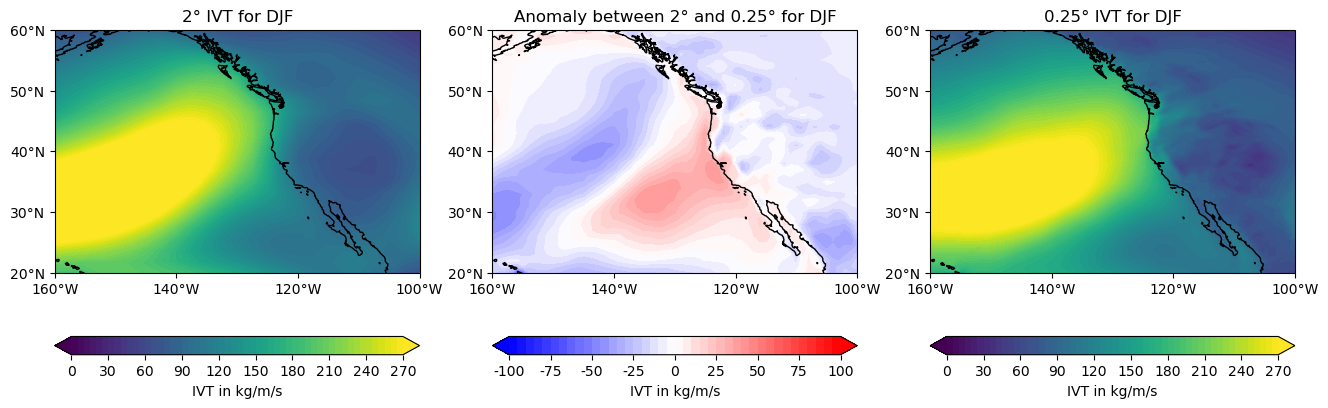

In [11]:
# Extract DJF from the IVT data
ivt1 = ds1.IVT[0:2,:,:]
ivt1_2 = ds1.IVT[11,:,:]
ivt3 = ds3.IVT[0:2,:,:]
ivt3_2 = ds3.IVT[11,:,:]

# Concatenate DJF together into one
ivt_1 = xr.concat([ivt1, ivt1_2], dim='time')
ivt_3 = xr.concat([ivt3, ivt3_2], dim='time')

# Average the data over DJF
ivt_1 = ivt_1.mean(dim='time')
ivt_3 = ivt_3.mean(dim='time')

# Array for colormaps
allcmaps = ['viridis', cmaps.MPL_bwr, 'viridis']

# Titles for the plots
titles = ['2° IVT for DJF', 'Anomaly between 2° and 0.25° for DJF', '0.25° IVT for DJF']

# Color bar title
cbar_title = 'IVT in kg/m/s'

# Levels for the plots
start_levels = [0, -100, 0]
end_levels = [275, 101, 275]

# File save path
path = '/home/vreddy6/code/project/output_plots/ivt_anom.pdf' 

# Plot the data
anom_panel_plot(ivt_1, ivt_3, start_levels, end_levels, titles, cbar_title, allcmaps, path, True, [-160, -100, 20, 60], 20, 10, step=5)